# 5G UE-VBS Selection ML Model

## Classification

In this notebook, we will build the classification model. This model will determine if a User Equipment (UE) can become a 5G Virtual Base Station (VBS) or not.

Target: **Eligibility**

- <strong>Environment setup:</strong> import libraries and load the dataset
- <strong>Data Analysis:</strong> understand the meaning and the predictive power of the variables 
- <strong>Feature Selection:</strong> evaluate and keep only the most relevant variables
- <strong>Preprocessing:</strong> encode categorical variables and partition the dataset for training and testing
- <strong>Model design:</strong> train and test various models
- <strong>Performance evaluation:</strong> evaluate the models based on their metrics
- <strong>Explainability:</strong> understand how the model produces results

## Environmnet Setup

In [1]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Model Selection
from sklearn.model_selection import cross_val_score

from scipy.stats import pointbiserialr

In [2]:
# Loading the dataset
dataset_location = './Data/master_simulation_1000_2500.csv'
df = pd.read_csv(dataset_location, index_col=0)
df.head()

,x,y,distance_from_base_station,battery_discharge_rate,power,memory,cpu_power,qos,qoe,data_rate,eligibility
0,134.467967,211.647510,465.575800,45.312870,9.301212,6,65.953269,0.992467,0.147388,3.237754e+04,False
1,583.456900,125.555800,383.632002,107.164485,10.982724,12,48.639950,0.993799,0.136998,4.545044e+05,False
2,367.394058,380.586430,178.448694,42.099486,17.630753,6,88.386756,0.995114,0.125348,4.774090e+04,False
3,263.133339,37.844211,519.320506,117.518415,8.352311,8,93.333433,0.992822,0.143667,1.416554e+06,False
4,61.528950,28.579757,643.812013,67.063529,6.485839,4,30.084433,0.992436,0.148444,5.775633e+04,False


AxesSubplot(0.125,0.125;0.698618x0.755)


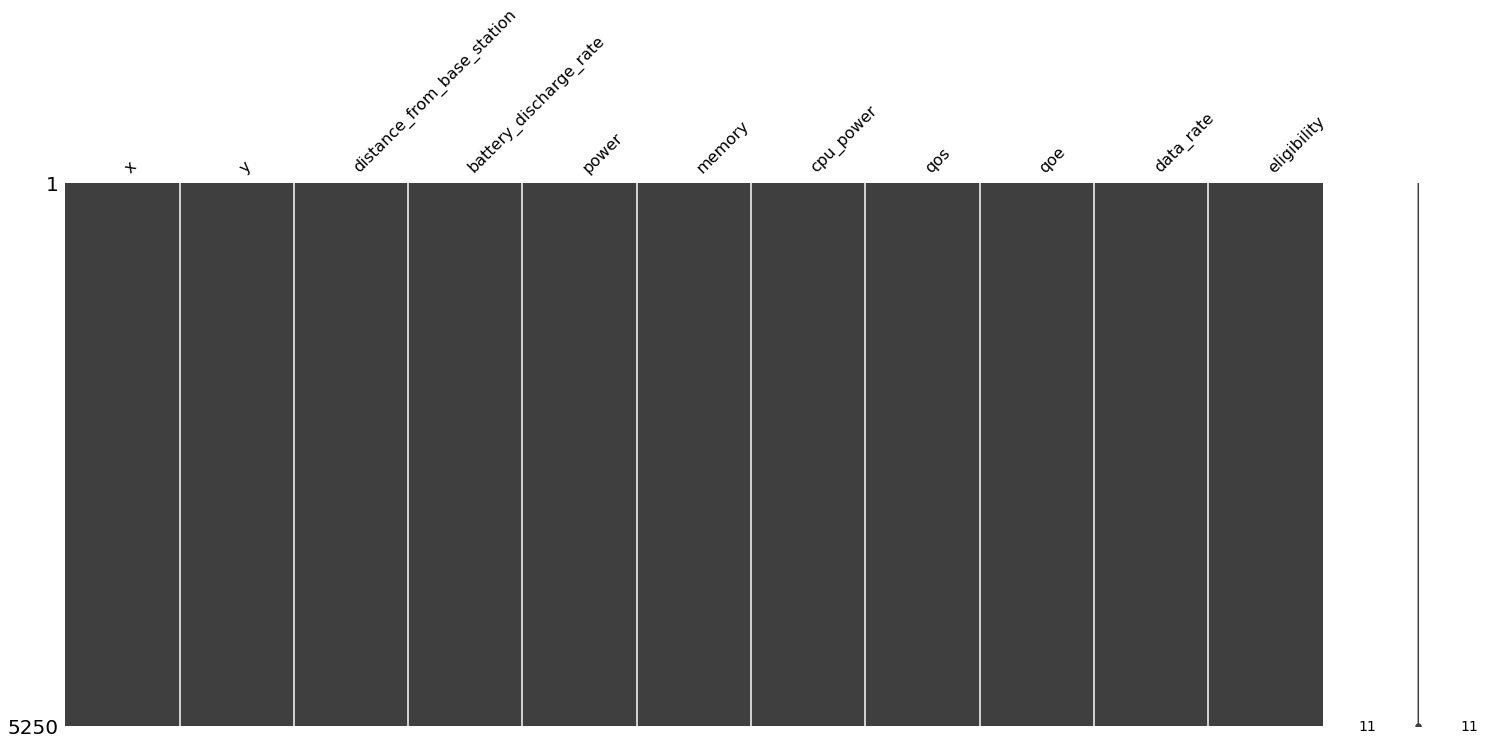

In [3]:
print(msno.matrix(df))

In [4]:
df = df.drop(['x', 'y'], axis=1)
df

,distance_from_base_station,battery_discharge_rate,power,memory,cpu_power,qos,qoe,data_rate,eligibility
0,465.575800,45.312870,9.301212,6,65.953269,0.992467,0.147388,3.237754e+04,False
1,383.632002,107.164485,10.982724,12,48.639950,0.993799,0.136998,4.545044e+05,False
2,178.448694,42.099486,17.630753,6,88.386756,0.995114,0.125348,4.774090e+04,False
3,519.320506,117.518415,8.352311,8,93.333433,0.992822,0.143667,1.416554e+06,False
4,643.812013,67.063529,6.485839,4,30.084433,0.992436,0.148444,5.775633e+04,False
...,...,...,...,...,...,...,...,...,...
5245,335.201631,42.854214,11.942236,6,14.992929,0.996490,0.095631,1.126151e+05,False
5246,399.576249,98.270340,10.416365,8,98.328262,0.996259,0.098850,2.371739e+06,False
5247,214.765611,53.136700,15.809064,12,55.446848,0.997809,0.076410,1.069651e+05,False
5248,275.915292,85.409301,13.632843,12,53.260666,0.996925,0.090078,2.350156e+05,False


In [5]:
# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   distance_from_base_station  5250 non-null   float64
 1   battery_discharge_rate      5250 non-null   float64
 2   power                       5250 non-null   float64
 3   memory                      5250 non-null   int64  
 4   cpu_power                   5250 non-null   float64
 5   qos                         5250 non-null   float64
 6   qoe                         5250 non-null   float64
 7   data_rate                   5250 non-null   float64
 8   eligibility                 5250 non-null   bool   
dtypes: bool(1), float64(7), int64(1)
memory usage: 374.3 KB
None

Shape: (5250, 9)


## Data Analysis

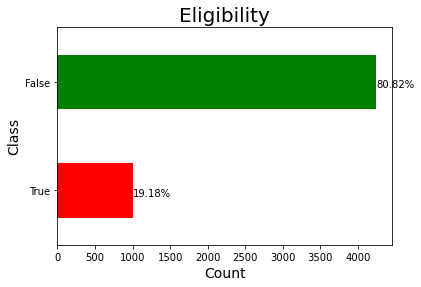

False    4243
True     1007
Name: eligibility, dtype: int64


In [6]:
# Plotting the percentage of observations that fall under each class
ax = df["eligibility"].value_counts().sort_values().plot(kind="barh", color=["r", "g"])
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Eligibility", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(df["eligibility"].value_counts())
fig = ax.get_figure()
fig.savefig("Fig/03-01-Class_Imbalance.png")
fig.savefig("Eps/03-01-Class_Imbalance.eps", format='eps')

### Point Biserial Correlation for Quantitative, Continuous Features with ArrDel15
A <strong>correlation coefficient</strong> measures the extent to which two variables tend to change together. The coefficient describes both the strength and the direction of the relationship. <br>
A <strong>point-biserial correlation (PBC)</strong> is used to measure the strength and direction of the association that exists between <strong>one continuous variable and one dichotomous variable</strong>.

In [7]:
# Encoding eligibility : categorical -> numeric
labelEncoder = LabelEncoder()
df["eligibility"] = labelEncoder.fit_transform(df["eligibility"])
df["eligibility"].head()

# get continuous and dichotomous data
categorical = ["memory", "eligibility"]
numeric = ["distance_from_base_station", "battery_discharge_rate", "power", "cpu_power", "qos", "qoe", "data_rate"]
target = df["eligibility"]

# pbc of first question
pbc = list()
for col in numeric:
    ans = pointbiserialr(df[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)
pbc_corr

,Feature,CorrCoeff,pValue
0,data_rate,0.227157,2.038732e-62
1,qoe,0.207547,3.511968e-52
2,cpu_power,0.118286,8.057369e-18
3,battery_discharge_rate,0.102077,1.227105e-13
4,power,0.031623,2.194416e-02
5,distance_from_base_station,-0.026995,5.048069e-02
6,qos,-0.184563,1.898806e-41


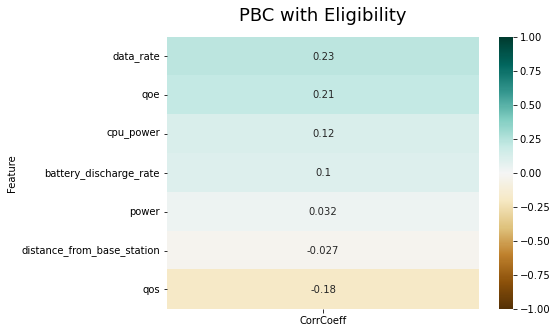

In [8]:
plt.figure(figsize=(7, 5))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("PBC with Eligibility", fontdict={"fontsize":18}, pad=16);
plt.savefig("Fig/03-02-PBC.png")
plt.savefig("Eps/03-02-PBC.eps", format='eps')
del pbc_corr

### Spearman Correlation for Monotonic Relationships with Categorical Features
The <strong>Spearman correlation</strong> evaluates the monotonic relationship between <strong>two continuous or ordinal variables</strong>. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data

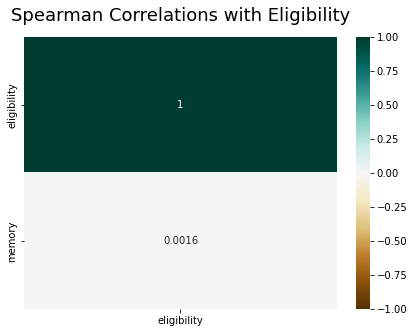

In [9]:
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df[categorical].corr(method="spearman")[["eligibility"]].sort_values(by="eligibility", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations with Eligibility", fontdict={"fontsize":18}, pad=16)
plt.savefig("Fig/03-03-Spearman.png")
plt.savefig("Eps/03-03-Spearman.eps", format='eps')
del heatmap

## Preprocessing for Classification

In [10]:
# Encoding eligibility : categorical -> numeric
labelEncoder = LabelEncoder()
df["eligibility"] = labelEncoder.fit_transform(df["eligibility"])
features = df.loc[:, df.columns != "eligibility"]
labels = np.asarray(df["eligibility"])
print(features.columns)

# Number of samples/observations/rows is greater than 100,000
print(f"\nDataset shape: {df.shape}")
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.30, random_state=42)
print(f"features_train shape: {features_train.shape} | features_test shape: {features_test.shape}")
print(f"labels_train shape: {labels_train.shape} | labels_test shape: {labels_test.shape}")
# print(f"{features_train.shape[1]} Features: {features_train.columns.to_list()}")
df.to_csv("./Data/encoded_master_simulation_1000_2500.csv")

Index(['distance_from_base_station', 'battery_discharge_rate', 'power',
       'memory', 'cpu_power', 'qos', 'qoe', 'data_rate'],
      dtype='object')

Dataset shape: (5250, 9)
features_train shape: (3675, 8) | features_test shape: (1575, 8)
labels_train shape: (3675,) | labels_test shape: (1575,)


### Feature Selection
A random forest classifier has been modeled to rank the importance of the features in the entire dataset to visualize which features provide relevant information.
<strong>Note: Uncomment the below code if you want to re-train the model</strong>

In [11]:
X = features_train
y = labels_train

model = RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=42, n_jobs=-1)

model.fit(X, y)
joblib.dump(model, "./Data/feature_importance_model.joblib")
model = joblib.load("./Data/feature_importance_model.joblib")
importances = model.feature_importances_
importances

array([0.04462437, 0.06861646, 0.04523226, 0.01426918, 0.07306929,
       0.11468288, 0.11442689, 0.52507867])

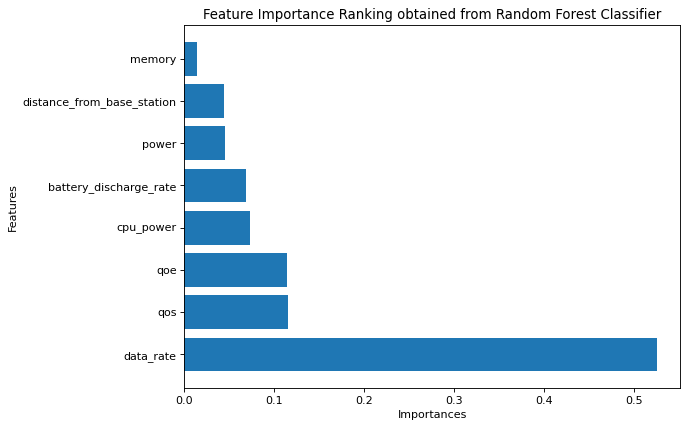

In [12]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")
plt.savefig("Fig/03-04-Feature_Selection.png")
plt.savefig("Eps/03-04-Feature_Selection.eps", format='eps')
del importances
del model
del X
del y

## Modeling Different Classifiers

### Random Forest Classifier

[[1261   20]
 [  59  235]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1281
           1       0.92      0.80      0.86       294

    accuracy                           0.95      1575
   macro avg       0.94      0.89      0.91      1575
weighted avg       0.95      0.95      0.95      1575


Cross-Validation cv=5
0.94 0.93 0.93 0.93 0.95 

Mean: 0.94


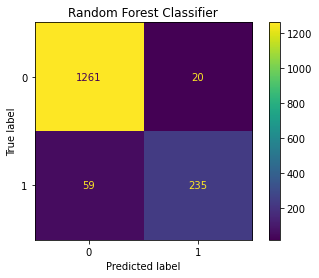

In [13]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./Classifiers/RandomForestClassifier.joblib")
model = joblib.load("./Classifiers/RandomForestClassifier.joblib")
model_pred = model.predict(features_test)
print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Random Forest Classifier")
plt.savefig("Fig/03-05-RFC_Confusion_Matrix.png")
plt.savefig("Eps/03-05-RFC_Confusion_Matrix.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

### Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1281
           1       0.93      0.81      0.86       294

    accuracy                           0.95      1575
   macro avg       0.94      0.90      0.92      1575
weighted avg       0.95      0.95      0.95      1575


Cross-Validation cv=5
0.95 0.93 0.95 0.94 0.94 

Mean: 0.94


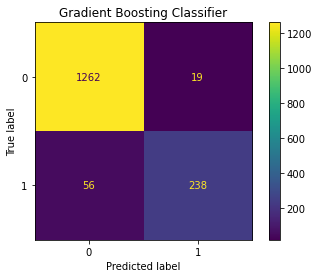

In [14]:
model = GradientBoostingClassifier(random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./Classifiers/GradientBoostingClassifier.joblib")
model = joblib.load("./Classifiers/GradientBoostingClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Gradient Boosting Classifier")
plt.savefig("Fig/03-06-GBC_Confusion_Matrix.png")
plt.savefig("Eps/03-06-GBC_Confusion_Matrix.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

### AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1281
           1       0.93      0.79      0.85       294

    accuracy                           0.95      1575
   macro avg       0.94      0.89      0.91      1575
weighted avg       0.95      0.95      0.95      1575


Cross-Validation cv=5
0.94 0.93 0.94 0.94 0.94 

Mean: 0.94


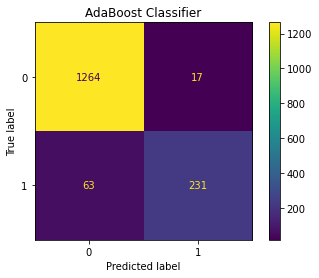

In [15]:
model = AdaBoostClassifier(random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./Classifiers/AdaBoostClassifier.joblib")
model = joblib.load("./Classifiers/AdaBoostClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("AdaBoost Classifier")
plt.savefig("Fig/03-07-AdaBoost_Confusion_Matrix.png")
plt.savefig("Eps/03-07-AdaBoost_Confusion_Matrix.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

## Performance Evaluation
The <strong>Receiver Operator Characteristic (ROC) curve</strong> is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The <strong>Area Under the Curve (AUC)</strong> is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
<br><br>
**The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.**

|AUC Value|Meaning|
|:--|:--|
|AUC = 1| The classifier is able to **perfectly distinguish** between all the Positive and the Negative class points correctly.|
|AUC = 0| The classifier would be predicting **all Negatives as Positives, and all Positives as Negatives**|
|0.5 < AUC < 1| There is a high chance that the classifier will be able to distinguish the classes i.e. more numbers of True positives and True negatives than False negatives and False positives|
|AUC=0.5| The classifier is not able to distinguish between Positive and Negative class points i.e. either the classifier is predicting random class or constant class for all the data points|

In [16]:
# Setup
perf_df = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

classifiers = ["AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier"]
for clf in classifiers:
    # Load the trained classifiers
    model = joblib.load(f"./Classifiers/{clf}.joblib")
    model_pred = model.predict(features_test)
    fpr, tpr, _ = roc_curve(labels_test,  model_pred)
    auc = roc_auc_score(labels_test, model_pred)
    # Record the results
    perf_df = perf_df.append({"classifiers": clf,
                                        "fpr": fpr, 
                                        "tpr": tpr, 
                                        "auc": auc}, ignore_index=True)
    del model
    del model_pred

# Set name of the classifiers as index labels
perf_df.set_index("classifiers", inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


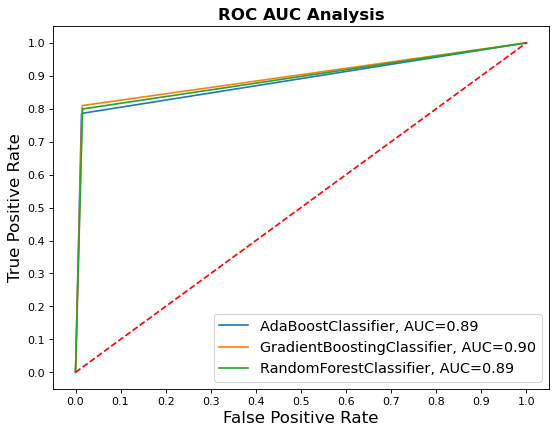

In [17]:
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in perf_df.index:
    plt.plot(perf_df.loc[clf_name]["fpr"], 
             perf_df.loc[clf_name]["tpr"], 
             label="{}, AUC={:.2f}".format(clf_name, perf_df.loc[clf_name]["auc"]))
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title("ROC AUC Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.savefig("Fig/03-08-ROCAUC_Before_SMOTE.png")
plt.savefig("Eps/03-08-ROCAUC_Before_SMOTE.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


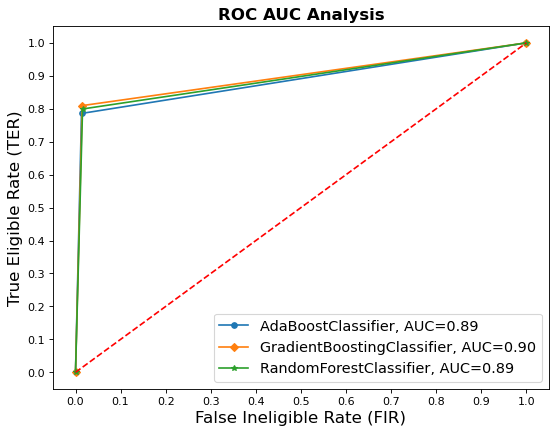

In [18]:
markers = 'oD*'
m = 0
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in perf_df.index:
    plt.plot(perf_df.loc[clf_name]["fpr"], 
             perf_df.loc[clf_name]["tpr"], marker=markers[m], markersize='5',
             label="{}, AUC={:.2f}".format(clf_name, perf_df.loc[clf_name]["auc"]))
    m += 1
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Ineligible Rate (FIR)", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Eligible Rate (TER)", fontsize=15)

plt.title("ROC AUC Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.savefig("Fig/03-09-ROCAUC_Before_SMOTE.png")
plt.savefig("Eps/03-09-ROCAUC_Before_SMOTE.eps", format='eps')
plt.show()